In [1]:
import numpy as np
import tensorflow as tf
import gzip
import pickle
import sys
import copy
import os.path
import pdb
import re
from ddm.run_split import SplitMnistGenerator
from ddm.alg.cla_models_multihead import MFVI_IBP_NN, Vanilla_NN
from ddm.alg.utils import get_scores, concatenate_results
from ddm.alg.vcl import run_vcl
from copy import deepcopy

from bayes_opt import BayesianOptimization

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

W0819 17:30:21.492286 140008901007168 deprecation_wrapper.py:119] From /home/skessler/Projects/IBP_BNN/ddm/alg/cla_models_multihead.py:9: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0819 17:30:21.493005 140008901007168 deprecation_wrapper.py:119] From /home/skessler/Projects/IBP_BNN/ddm/alg/cla_models_multihead.py:13: The name tf.set_random_seed is deprecated. Please use tf.compat.v1.set_random_seed instead.



# IBP network

In [2]:
hidden_size = [100]
batch_size = 128
no_epochs = 100
alpha0 = 1.0
tau0=1.0 # initial temperature
ANNEAL_RATE=0.000
MIN_TEMP=0.1

# Run vanilla VCL
tf.set_random_seed(12)
np.random.seed(1)

ibp_acc = np.array([])

coreset_size = 0
val = True
data_gen = SplitMnistGenerator(val)
single_head=False
in_dim, out_dim = data_gen.get_dims()
x_testsets, y_testsets = [], []
x_valsets, y_valsets = [], []
for task_id in range(data_gen.max_iter):
    
    tf.reset_default_graph()
    if val:
        x_train, y_train, x_test, y_test, x_val, y_val = data_gen.next_task()
        x_valsets.append(x_val)
        y_valsets.append(y_val)
    else:    
        x_train, y_train, x_test, y_test = data_gen.next_task()
    x_testsets.append(x_test)
    y_testsets.append(y_test)

    # Set the readout head to train
    head = 0 if single_head else task_id
    bsize = x_train.shape[0] if (batch_size is None) else batch_size
    
    # Train network with maximum likelihood to initialize first model
    if task_id == 0:
        ml_model = Vanilla_NN(in_dim, hidden_size, out_dim, x_train.shape[0])
        ml_model.train(x_train, y_train, task_id, no_epochs, bsize)
        mf_weights = ml_model.get_weights()
        mf_variances = None
        mf_betas = None
        ml_model.close_session()

    # Train on non-coreset data
    mf_model = MFVI_IBP_NN(in_dim, hidden_size, out_dim, x_train.shape[0], prev_means=mf_weights, 
                           prev_log_variances=mf_variances, prev_betas=mf_betas,alpha0=alpha0,
                           learning_rate=0.01, temp=tau0, temp_prior=1.0, no_pred_samples=100)
    mf_model.train(x_train, y_train, head, no_epochs, bsize,
                   anneal_rate=ANNEAL_RATE, min_temp=MIN_TEMP)
    mf_weights, mf_variances, mf_betas = mf_model.get_weights()

    acc = get_scores(mf_model, x_valsets, y_valsets, single_head)
    ibp_acc = concatenate_results(acc, ibp_acc)
    
    mf_model.close_session()
    
ibp_acc

W0817 10:52:12.129490 140686037821248 deprecation_wrapper.py:119] From /home/skessler/Projects/IBP_BNN/ddm/alg/cla_models_multihead.py:56: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0817 10:52:12.132290 140686037821248 deprecation_wrapper.py:119] From /home/skessler/Projects/IBP_BNN/ddm/alg/cla_models_multihead.py:167: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0817 10:52:12.188359 140686037821248 deprecation_wrapper.py:119] From /home/skessler/Projects/IBP_BNN/ddm/alg/cla_models_multihead.py:61: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

W0817 10:52:12.303390 140686037821248 deprecation_wrapper.py:119] From /home/skessler/Projects/IBP_BNN/ddm/alg/cla_models_multihead.py:65: The name tf.global_variables_initializer is deprecated. Please use tf.compat.v1.global_variables_initializer instead.



Epoch: 0001 cost= 0.049326868
Epoch: 0006 cost= 0.000994026
Epoch: 0011 cost= 0.000234237
Epoch: 0016 cost= 0.000100588
Epoch: 0021 cost= 0.000055076
Epoch: 0026 cost= 0.000033257
Epoch: 0031 cost= 0.000021853
Epoch: 0036 cost= 0.000014344
Epoch: 0041 cost= 0.000010315
Epoch: 0046 cost= 0.000007250
Epoch: 0051 cost= 0.000005240
Epoch: 0056 cost= 0.000003922
Epoch: 0061 cost= 0.000002916
Epoch: 0066 cost= 0.000002214
Epoch: 0071 cost= 0.000001703
Epoch: 0076 cost= 0.000001282


KeyboardInterrupt: 

In [ ]:
# Run Vanilla VCL
tf.reset_default_graph()
tf.set_random_seed(12)
np.random.seed(1)
hidden_size = [10]
coreset_size = 0

data_gen = SplitMnistGenerator()
vcl_result = run_vcl(hidden_size, no_epochs, data_gen, 
                              lambda a: a, coreset_size, batch_size, single_head)
print(vcl_result)

In [ ]:
# # Run IBP VCL
# tf.reset_default_graph()
# tf.set_random_seed(12)
# np.random.seed(1)
# coreset_size = 0

# hidden_size = [50]
# batch_size = 128
# no_epochs = 100
# alpha0 = 5.0
# tau0=0.1 # initial temperature
# temp_prior=1.0
# ANNEAL_RATE=0.000
# MIN_TEMP=0.1
# single_head=False

# # data_gen = SplitMnistGenerator()
# # vcl_ibp_result = vcl.run_vcl_ibp(hidden_size=hidden_size, no_epochs=no_epochs, data_gen=data_gen,
# #                                   batch_size=batch_size, single_head=single_head, alpha0=alpha0,
# #                                   learning_rate=0.01, temp_prior=temp_prior, no_pred_samples=100,
# #                                   tau0=tau0, tau_anneal_rate=ANNEAL_RATE, tau_min=MIN_TEMP)
# # print(vcl_ibp_result)

In [ ]:
_ibp_acc = np.nanmean(ibp_acc, 1)
_vcl_result = np.nanmean(vcl_result, 1)

In [ ]:
_vcl_result

In [ ]:
plt.rc('text', usetex=True)
#plt.rc('font', family='serif')

fig = plt.figure(figsize=(7,3))
ax = plt.gca()
plt.plot(np.arange(len(_ibp_acc))+1, _ibp_acc, label='VCL + IBP', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result, label='VCL', marker='o')
ax.set_xticks(range(1, len(_ibp_acc)+1))
ax.set_ylabel('Average accuracy')
ax.set_xlabel('\# tasks')
ax.legend()
fig.show()

# Weight pruning

In [2]:
class MFVI_IBP_NN_prune(MFVI_IBP_NN):
    def __init__(self, input_size, hidden_size, output_size, training_size,
                 no_train_samples=10, no_pred_samples=100, prev_means=None, prev_log_variances=None,
                 prev_betas=None, learning_rate=0.001,
                 prior_mean=0, prior_var=1, alpha0=5., beta0=1., lambda_1=1., lambda_2=1.,
                 tensorboard_dir='logs', name='ibp_wp', min_temp=0.5, tb_logging=True,
                output_tb_gradients=True):

        super(MFVI_IBP_NN_prune, self).__init__(input_size, hidden_size, output_size, training_size,
                 no_train_samples, no_pred_samples, prev_means, prev_log_variances,
                 prev_betas, learning_rate,
                 prior_mean, prior_var, alpha0, beta0, lambda_1, lambda_2,
                 tensorboard_dir, name, min_temp, tb_logging, output_tb_gradients=True)


    def prune_weights(self, X_test, Y_test, task_id):
        """ Performs weight pruning
        Args:
            X_test: numpy array
            Y_test: numpy array
            task_id: int
        :return: cutoffs, accs via naive pruning, accs via snr pruning,
        weight values, sigma values of network
        """

        def reset_weights(pr_mus, pr_sigmas, _mus, _sigmas):
            """ Reset weights of graph to original values
            Args:
                pr_mus: list of tf variables which have been pruned
                pr_sigmas: list of tf variables which have been pruned
                _mus: list of cached mus in numpy
                _sigmas: list of cached sigmas in numpy
            """

            for v, _v in zip(pr_mus, _mus):
                self.sess.run(tf.assign(v, tf.cast(_v, v.dtype)))

            for v, _v in zip(pr_sigmas, _sigmas):
                self.sess.run(tf.assign(v, tf.cast(_v, v.dtype)))

        def pruning(remove_pct, weightvalues_ibp, weightvalues, sigmavalues,
                    weights, sigmas, uncert_pruning=True):
            """ Performs weight pruning experiment
            Args:
                weightvalues_ibp: np array of weights with ibp mask applied
                weightvalues: np array of weights
                sigmavalues: np array of sigmas
                weights: list of tf weight variable
                sigmas: list of tf sigma variables
                uncert_pruning: bool pruning by snr
            """
            if uncert_pruning:
                sorted_STN = np.sort(np.abs(weightvalues_ibp) / sigmavalues)
            else:
                sorted_STN = np.sort(np.abs(weightvalues))
            cutoff = sorted_STN[int(remove_pct * len(sorted_STN))]
            
            # Weights, biases and head weights
            for v, s in zip(weights, sigmas):
                if uncert_pruning:
                    snr = tf.abs(v) / tf.exp(0.5*s)
                    mask = tf.greater_equal(snr, cutoff)
                else:
                    mask = tf.greater_equal(tf.abs(v), cutoff)
                self.sess.run(tf.assign(v, tf.multiply(v, tf.cast(mask, v.dtype))))
                self.sess.run(tf.assign(s, tf.multiply(s, tf.cast(mask, s.dtype))))  # also apply zero std to weight!!!
                
            
            accs = []
            for _ in range(10):
                accs.append(self.sess.run(self.acc, {self.x: X_test,
                                                     self.y: Y_test,
                                                     self.task_idx: task_id,
                                                     self.temp: self.lambda_1,
                                                     self.training: False}))
            print("%.2f, %s" % (np.sum(sorted_STN < cutoff) / len(sorted_STN), np.mean(accs)))
            return np.mean(accs)

        # get weights
        weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=tf.get_variable_scope().name)
        
        # Get weights from network
        # TODO get head weights and biases
        mus_w = []
        mus_b = []
        sigmas_w = []
        sigmas_b = []
        mus_h = [] # weights and biases
        sigmas_h = [] # weights and biases
        for v in weights:
            if re.match("^([w])(_mu_)([0-9]+)(:0)$", v.name):
                mus_w.append(v)
            elif re.match("^([w])(_sigma_)([0-9]+)(:0)$", v.name):
                sigmas_w.append(v)
            elif re.match("^([b])(_mu_)([0-9]+)(:0)$", v.name):
                mus_b.append(v)
            elif re.match("^([b])(_sigma_)([0-9]+)(:0)$", v.name):
                sigmas_b.append(v)
            elif re.match("^([wb])(_mu_h_)([0-9]+)(:0)$", v.name):
                mus_h.append(v)
            elif re.match("^([wb])(_sigma_h_)([0-9]+)(:0)$", v.name):
                sigmas_h.append(v)
            else:
                print("Un-matched: {}".format(v.name))
                
        # Get mask
        # Need to apply mask to weights and biases for pruning
        # Do not apply to head weights though!
        # Zs \in [x_test.size, dout], just need one sample of Z!
        Zs = self.sess.run(self.Z, {self.x: X_test,
                                    self.y: Y_test,
                                    self.task_idx: task_id,
                                    self.temp: self.lambda_1,
                                    self.training: False})[0] # z mask for each layer in a list, each Z \in dout

        # cache network weights of resetting the network
        _mus_w = [self.sess.run(w) for w in mus_w]
        _sigmas_w = [self.sess.run(w) for w in sigmas_w]
        _mus_b = [self.sess.run(w) for w in mus_b]
        _sigmas_b = [self.sess.run(w) for w in sigmas_b]
        _mus_h = [self.sess.run(w) for w in mus_h]
        _sigmas_h = [self.sess.run(w) for w in sigmas_h]

        # flatten values for cut-off finding
        # Tile Zs [dout] --> [din, dout]
        dins = [x.shape[0] for x in _mus_w]
        Z_tiled = []
        t_Z_tiled = []
        for i in range(len(dins)):
            Z_tiled.append(np.tile(Zs[i][0, :], (dins[i], 1))) 
            t_Z_tiled.append(tf.tile(tf.squeeze(self.Z[i], axis=0), [dins[i], 1]))
        
        # multiply Zs with 
        xx = []
        yy = []
        for i in range(len(mus_w)):
            xx.append(np.multiply(self.sess.run(mus_w[i]), Z_tiled[i]).flatten())
            yy.append(np.multiply(self.sess.run(mus_b[i]), Zs[i][0,:]).flatten())
        
        # flatten head network weights
        f_mus_h = []
        f_sigmas_h = []
        for i in range(len(f_mus_h)):
            f_mus_h.append(f_mus_h[i].flatten())
            f_sigmas_h.append(f_sigmas_h[i].flatten())
        
        weightvalues_ibp = np.hstack(np.array(xx + yy + f_mus_h))
        weightvalues = np.hstack(np.array([self.sess.run(w).flatten() for w in mus_w + mus_b + f_mus_h]))
        sigmavalues_tr = np.hstack(np.array([self.sess.run(tf.exp(0.5*s)).flatten() for s in sigmas_w + sigmas_b + f_sigmas_h]))
    
        xs = np.append(0.05 * np.array(range(20)), np.array([0.98, 0.99, 0.999]))
        ya = []
        for pct in xs:
            ya.append(pruning(pct, weightvalues_ibp, weightvalues, sigmavalues_tr,
                              mus_w + mus_b + f_mus_h, sigmas_w + sigmas_b + f_sigmas_h, 
                              uncert_pruning=False))

        # reset etc.
        reset_weights(mus_w, sigmas_w, _mus_w, _sigmas_w)
        reset_weights(mus_b, sigmas_b, _mus_b, _sigmas_b)
        yb = []
        for pct in xs:
            yb.append(pruning(pct, weightvalues_ibp, weightvalues, sigmavalues_tr,
                              mus_w + mus_b + f_mus_h, sigmas_w + sigmas_b + f_sigmas_h,
                              uncert_pruning=True))
            
        reset_weights(mus_w, sigmas_w, _mus_w, _sigmas_w)
        reset_weights(mus_b, sigmas_b, _mus_b, _sigmas_b)
        
        return xs, ya, yb, weightvalues, sigmavalues_tr

In [21]:
hidden_size = [100]
batch_size = 128
no_epochs = 200
alpha0 = 1.0
tau0=1.0 # initial temperature
ANNEAL_RATE=0.000
MIN_TEMP=0.1

tf.set_random_seed(12)
np.random.seed(1)

ibp_acc = np.array([])

coreset_size = 0
val = False
data_gen = SplitMnistGenerator(val, num_tasks=1)
single_head=False
in_dim, out_dim = data_gen.get_dims()
x_testsets, y_testsets = [], []
x_valsets, y_valsets = [], []
for task_id in range(data_gen.max_iter):
    
    tf.reset_default_graph()
    if val:
        x_train, y_train, x_test, y_test, x_val, y_val = data_gen.next_task()
        x_valsets.append(x_val)
        y_valsets.append(y_val)
    else:    
        x_train, y_train, x_test, y_test = data_gen.next_task()
    x_testsets.append(x_test)
    y_testsets.append(y_test)

    # Set the readout head to train
    head = 0 if single_head else task_id
    bsize = x_train.shape[0] if (batch_size is None) else batch_size
    
    # Train network with maximum likelihood to initialize first model
    if task_id == 0:
        ml_model = Vanilla_NN(in_dim, hidden_size, out_dim, x_train.shape[0])
        ml_model.train(x_train, y_train, task_id, 100, bsize)
        mf_weights = ml_model.get_weights()
        mf_variances = None
        mf_betas = None
        ml_model.close_session()

    # Train on non-coreset data
    mf_model = MFVI_IBP_NN_prune(in_dim, hidden_size, out_dim, x_train.shape[0], prev_means=mf_weights, 
                           prev_log_variances=mf_variances, prev_betas=mf_betas,alpha0=alpha0,
                           learning_rate=0.01, lambda_1=tau0, lambda_2=1.0, no_pred_samples=100)
    mf_model.train(x_train, y_train, head, no_epochs, bsize,
                   anneal_rate=ANNEAL_RATE, min_temp=MIN_TEMP)
    
    xs, ya, yb, _, _  = mf_model.prune_weights(x_test, y_test, head)
    
    mf_model.close_session()

Epoch: 0001 cost= 0.054196305
Epoch: 0006 cost= 0.000863743
Epoch: 0011 cost= 0.000250822
Epoch: 0016 cost= 0.000103665
Epoch: 0021 cost= 0.000056164
Epoch: 0026 cost= 0.000033193
Epoch: 0031 cost= 0.000021623
Epoch: 0036 cost= 0.000014372
Epoch: 0041 cost= 0.000009759
Epoch: 0046 cost= 0.000006962
Epoch: 0051 cost= 0.000005267
Epoch: 0056 cost= 0.000003606
Epoch: 0061 cost= 0.000002610
Epoch: 0066 cost= 0.000001964
Epoch: 0071 cost= 0.000001434
Epoch: 0076 cost= 0.000001076
Epoch: 0081 cost= 0.000000800
Epoch: 0086 cost= 0.000000638
Epoch: 0091 cost= 0.000000445
Epoch: 0096 cost= 0.000000340
Optimization Finished!
z_discrete: (1, ?, 100)
biases: <unknown>
pre: <unknown>
z_discrete: (1, ?, 100)
biases: <unknown>
pre: <unknown>
z_discrete: (1, ?, 100)
biases: <unknown>
pre: <unknown>
_Z: (1, ?, 100)
Epoch: 0001 train cost= 19.067509160
Epoch: 0006 train cost= 5.154825288
Epoch: 0011 train cost= 3.800348641
Epoch: 0016 train cost= 3.660439990
Epoch: 0021 train cost= 3.549343988
Epoch: 00

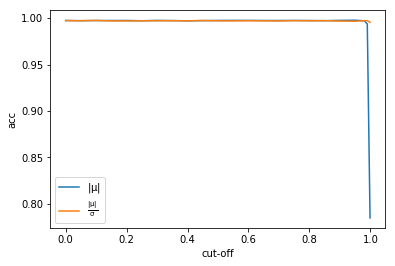

In [23]:
plt.plot(xs, ya, label='$|\mu|$')
plt.plot(xs, yb, label='$ \\frac{|\mu|}{\sigma}$')
plt.xlabel('cut-off')
plt.ylabel('acc')
plt.legend()
plt.show()

# Multiclass CLF Weight Pruning

In [3]:
class MnistGenerator():
    def __init__(self, max_iter=10):
        with gzip.open('ddm/data/mnist.pkl.gz', 'rb') as f:
            train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

        self.X_train = np.vstack((train_set[0], valid_set[0]))
        self.Y_train = np.hstack((train_set[1], valid_set[1]))
        self.X_test = test_set[0]
        self.Y_test = test_set[1]
        self.max_iter = max_iter
        self.cur_iter = 0

    def get_dims(self):
        # Get data input and output dimensions
        return self.X_train.shape[1], 10

    def task(self):
        # Retrieve train data
        x_train = deepcopy(self.X_train)
        y_train = np.eye(10)[self.Y_train]

        # Retrieve test data
        x_test = deepcopy(self.X_test)
        y_test = np.eye(10)[self.Y_test]
        
        return x_train, y_train, x_test, y_test

In [5]:
hidden_size = [100]
batch_size = 128
no_epochs = 500
ANNEAL_RATE=0.000
MIN_TEMP=0.1

tf.set_random_seed(12)
np.random.seed(1)

ibp_acc = np.array([])

coreset_size = 0
data_gen = MnistGenerator()
single_head=False
in_dim, out_dim = data_gen.get_dims()
x_testsets, y_testsets = [], []
task_id=0
    
tf.reset_default_graph()  
x_train, y_train, x_test, y_test = data_gen.task()
x_testsets.append(x_test)
y_testsets.append(y_test)

# Set the readout head to train
head = 0 if single_head else task_id
bsize = x_train.shape[0] if (batch_size is None) else batch_size

# Train network with maximum likelihood to initialize first model
if task_id == 0:
    ml_model = Vanilla_NN(in_dim, hidden_size, out_dim, x_train.shape[0])
    ml_model.train(x_train, y_train, task_id, 100, bsize)
    mf_weights = ml_model.get_weights()
    mf_variances = None
    mf_betas = None
    ml_model.close_session()

# Train on non-coreset data
mf_model = MFVI_IBP_NN_prune(in_dim, hidden_size, out_dim, x_train.shape[0], prev_means=mf_weights, 
                       prev_log_variances=mf_variances, prev_betas=mf_betas,alpha0=5.0, beta0=1.0,
                       learning_rate=0.0001, lambda_1=1.0, lambda_2=1.0, no_pred_samples=100,
                       name='ibp_wp_mnist')

mf_model.restore(os.path.join("logs", "graph_{}_task{}".format('ibp_wp_mnist', 0)))
# mf_model.train(x_train, y_train, head, no_epochs, bsize,
#                anneal_rate=ANNEAL_RATE, min_temp=MIN_TEMP)

xs, ya, yb, _, _  = mf_model.prune_weights(x_test, y_test, head)

mf_model.close_session()

Epoch: 0001 cost= 0.408574541
Epoch: 0006 cost= 0.074759072
Epoch: 0011 cost= 0.035776014
Epoch: 0016 cost= 0.018115912
Epoch: 0021 cost= 0.009480936
Epoch: 0026 cost= 0.004768397
Epoch: 0031 cost= 0.004363418
Epoch: 0036 cost= 0.005698155
Epoch: 0041 cost= 0.000524980
Epoch: 0046 cost= 0.000367317
Epoch: 0051 cost= 0.005180777
Epoch: 0056 cost= 0.000202681
Epoch: 0061 cost= 0.000124391
Epoch: 0066 cost= 0.000157842
Epoch: 0071 cost= 0.000091161
Epoch: 0076 cost= 0.010445531
Epoch: 0081 cost= 0.000090337
Epoch: 0086 cost= 0.000052465
Epoch: 0091 cost= 0.000771823
Epoch: 0096 cost= 0.000055726
Optimization Finished!
_Z: (1, ?, 100)


W0819 17:33:20.869965 140008901007168 deprecation.py:323] From /home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Un-matched: w_0:0
Un-matched: b_0:0
Un-matched: w_h_0:0
Un-matched: b_h_0:0
Un-matched: beta_a_0:0
Un-matched: beta_b_0:0
0.00, 0.92327654
0.05, 0.9235799
0.10, 0.92384684
0.15, 0.92296094
0.20, 0.92258966
0.25, 0.9236393
0.30, 0.92348444
0.35, 0.9230534
0.40, 0.9232804
0.45, 0.92349374
0.50, 0.92324525
0.55, 0.92340314
0.60, 0.92254096
0.65, 0.9204912
0.70, 0.9074329
0.75, 0.8741002
0.80, 0.8230032
0.85, 0.7541254
0.90, 0.6573881
0.95, 0.50270617
0.98, 0.3179967
0.99, 0.23368928
1.00, 0.1267716
0.00, 0.9236741
0.00, 0.9232396
0.00, 0.92255974
0.00, 0.92225707
0.00, 0.9233879
0.00, 0.92320204
0.30, 0.9230297
0.35, 0.92319334
0.40, 0.92318326
0.45, 0.92354095
0.50, 0.9230132
0.55, 0.92322814
0.60, 0.92365617
0.65, 0.922624
0.70, 0.9230455
0.75, 0.92294866
0.80, 0.92293864
0.85, 0.9170517
0.90, 0.89981115
0.95, 0.83589095
0.98, 0.7055582
0.99, 0.5721121
1.00, 0.260612


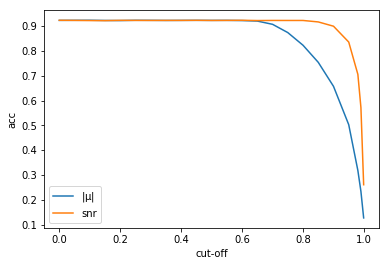

In [7]:
plt.plot(xs, ya, label='$|\mu|$')
plt.plot(xs, yb, label='snr')
plt.xlabel('cut-off')
plt.ylabel('acc')
plt.legend()
plt.show()